In [1]:
import os
import tensorflow as tf
import numpy as np
import math
from random import sample, shuffle
from PIL import Image
import matplotlib.pyplot as plt
from src.DataGenerator import AudioDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

In [159]:
data_gen = AudioDataGenerator(
    directory='data/Spotify/comp_pngs/', 
    image_size=(128,512), 
    color_mode='rgb',
    batch_size=64,
    sample_size=100000,
    shuffle=True,
    train_test_split=True, 
    test_size=0.02,
    output_channel_index=0,
    output_size=(128,128))



Found 98000 files for Training set
Found 2000 files for Test set


In [171]:
img_width = 128
img_height = 128
kernel_size = (3,3)
strides = (2,2)


class Autoencoder(tf.keras.Model):
    
    def __init__(self, latent_dim, num_channels):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Sequential([
            Conv2D(input_shape=(img_height, img_width, num_channels), filters=32, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=64, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=128, kernel_size=kernel_size, padding="same", strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=256, kernel_size=kernel_size, padding="same",strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Conv2D(filters=512, kernel_size=kernel_size, padding="same",strides=strides, activation='relu'),
            BatchNormalization(axis=-1),
            Flatten(),
            Dense(units=latent_dim, activation='tanh')
        ])
        self.decoder = Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            Dense(units=8192, activation='relu'),
            BatchNormalization(axis=-1),
            Reshape(target_shape=(4,4,512)),
            Conv2DTranspose(filters=512, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=256, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=128, kernel_size=kernel_size, strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=64, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=32, kernel_size=kernel_size,  strides=strides, padding="same", activation="relu"),
            BatchNormalization(axis=-1),
            Conv2DTranspose(filters=num_channels, kernel_size=kernel_size, padding="same", activation='sigmoid'),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = Autoencoder(128, 1)

opt = Adam(learning_rate=1e-3)

autoencoder.compile(optimizer=opt, loss=tf.keras.losses.mse)

In [172]:
# autoencoder.load_weights('data/autoencoder_128dim_512f_tanh')

In [186]:
hist_2 = autoencoder.fit(data_gen.train,
                       batch_size=data_gen.batch_size,
                       epochs=10,
                       validation_data=data_gen.test)

Epoch 1/5
  22/1531 [..............................] - ETA: 20:00 - loss: 0.0067

KeyboardInterrupt: 

In [178]:
autoencoder_path = 'data/autoencoder_128dim_512f_tanh'
autoencoder.save(autoencoder_path)

INFO:tensorflow:Assets written to: data/autoencoder_128dim_512f_tanh/assets


INFO:tensorflow:Assets written to: data/autoencoder_128dim_512f_tanh/assets


In [179]:
prediction_gen = AudioDataGenerator(
    directory='data/Spotify/comp_pngs/', 
    image_size=(128,512),
    color_mode='rgb',
    batch_size=1,
    shuffle=False,
    output_channel_index=0,
    output_size=(128,128))

Found 278326 files for Generator set


<Figure size 1440x360 with 0 Axes>

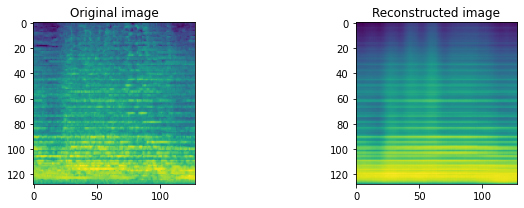

In [209]:
from src.helper_functions import plot_reconstruction
import matplotlib.pyplot as plt

test_img = prediction_gen.take(237075)[0]
prediction = autoencoder(test_img)

plt.figure(figsize=(20,5))

plot_reconstruction(test_img, prediction, 1)

In [187]:
from src.LatentSpace import LatentSpace

latent_space = LatentSpace(autoencoder_path=autoencoder_path,
                        image_dir='data/Spotify/comp_pngs/',
                        tracks_feather_path='data/all_tracks.feather', latent_dims=128, output_size=(128, 128)
                        )

Found 278326 files for Generator set


In [188]:
latent_space.build()


Getting predictions from autoencoder...
[============================================================>] 8697 / 8697

24.43 minutes elapsed
Building tracks dataframe...
size of results 1113216
Track dataframe built. 14.56 minutes elapsed
Building artist distributions...
Artist distributions built. 0.0 minutes elapsed
Building genre distributions...
Genre distributions built. 2.43 minutes elapsed
Latent Space Built.


FileNotFoundError: [Errno 2] Failed to open local file 'data/latent_space_128dim_512f_tanh//tracks.feather'. Detail: [errno 2] No such file or directory

In [198]:
try:
    os.mkdir('data/latent_space_128dim_512f_tanh')
except:
    pass
latent_space.save('data/latent_space_128dim_512f_tanh')